In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

from sklearn.model_selection import StratifiedKFold

import dill as pickle
import pandas as pd

import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

from tqdm import tnrange, tqdm_notebook


### Constants

In [3]:
PATH='data/happiness/'
TRN_FILE = f'{PATH}/train.csv'
TST_FILE = f'{PATH}/test.csv'


SUBS = f'{PATH}/submissions/'

bs=20; bptt=75
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
n_splits = 10


# Test settings
#TRN_FILE = f'{PATH}/train-small.csv'
#TST_FILE = f'{PATH}/test-small.csv'
#n_splits=2

### Read in data, split training and validation

In [4]:
full_train_df = pd.read_csv(TRN_FILE, index_col=0)
full_train_df.Is_Response.replace(['not happy', 'happy'], [0, 1], inplace=True)

test_df = pd.read_csv(TST_FILE)

strat = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
cv_splits_tmp = strat.split(full_train_df.index,
                            full_train_df['Is_Response'])
cv_splits = []
for split in cv_splits_tmp:
    cv_splits.append(split)

### Inspecting data

In [14]:
train_df['device_happy'] = train_df['Device_Used']+'_'+train_df['Is_Response']
train_df['browser_happy'] = train_df['Browser_Used']+'_'+train_df['Is_Response']

In [15]:
def plot(var, df):
    data = [go.Bar(
                x = df[var].unique(),
                y = df[var].value_counts().values,
                marker= dict(colorscale='Jet',
                             color = df[var].value_counts().values
                            ),
                text='Number of comments for this category'
        )]
    layout = go.Layout(
        title='Target variable distribution',
        xaxis = dict(categoryorder='category ascending')
    )

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename='basic-bar')


In [16]:
plot('Is_Response', train_df)

In [17]:
plot('device_happy', train_df)

In [34]:
plot('Device_Used', train_df)

In [35]:
plot('Browser_Used', train_df)

In [18]:
plot('browser_happy', train_df)

### Build language model

In [ ]:
lang_train_df=pd.concat([test_df,full_train_df])

In [7]:
TEXT = torchtext.data.Field(lower=True, tokenize=spacy_tok)

In [8]:
md = LanguageModelData.from_dataframes(PATH, TEXT, 'Description',
      train_df, tiny_df, tiny_df, bs=bs, bptt=bptt, min_freq=7)

In [9]:
pickle.dump(TEXT, open(f'{PATH}/models/h5TEXT.pkl','wb'))

In [10]:
mult=2
DROPOUT=dict(dropouti=0.05*mult, dropout=0.05*mult, wdrop=0.1*mult, dropoute=0.02*mult, dropouth=0.05*mult)

In [11]:
learner = md.get_model(opt_fn, em_sz, nh, nl, **DROPOUT)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [8]:
lrf=learner.lr_find()

A Jupyter Widget

 81%|████████▏ | 966/1187 [02:51<00:39,  5.63it/s, loss=nan] 

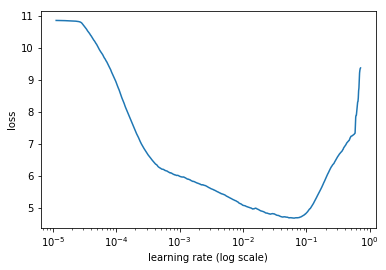

In [9]:
learner.sched.plot()

In [18]:
learner.fit(1e-2, 5, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam1')

[ 0.       4.4612   4.67984]                                  
[ 1.       3.8485   3.91509]                                  
[ 2.       3.70472  3.7656 ]                                  
[ 3.       3.75487  3.82334]                                  
[ 4.       3.67886  3.74017]                                  
[ 5.       3.58253  3.64084]                                  
[ 6.       3.56181  3.5991 ]                                  
[ 7.       3.72164  3.77158]                                  
[ 8.       3.68869  3.76386]                                  
[ 9.       3.64241  3.69053]                                  
[ 10.        3.59604   3.65759]                               
[ 11.        3.55332   3.59549]                               
[ 12.        3.50279   3.53896]                               
[ 13.        3.47026   3.50995]                               
[ 14.        3.45431   3.47282]                               
[ 15.        3.65736   3.70558]                        

In [19]:
learner.fit(1e-2, 4, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam2')

[ 0.       3.48213  3.49222]                                  
[ 1.       3.54198  3.57655]                                  
[ 2.       3.42899  3.46079]                                  
[ 3.       3.59254  3.64131]                                  
[ 4.       3.51461  3.54973]                                  
[ 5.       3.42882  3.46854]                                  
[ 6.       3.37162  3.38402]                                  
[ 7.       3.59175  3.72203]                                  
[ 8.       3.57833  3.62001]                                  
[ 9.       3.54232  3.57926]                                  
[ 10.        3.48887   3.53993]                               
[ 11.        3.42035   3.49491]                               
[ 12.        3.39485   3.41802]                               
[ 13.        3.34289   3.38387]                               
[ 14.        3.32934   3.35825]                               



In [20]:
learner.fit(1e-2, 2, wds=1e-6, cycle_save_name='h5_adam4')

[ 0.       3.59194  3.64874]                                  
[ 1.       3.59391  3.63885]                                  
[ 2.       3.5902   3.62841]                                  



In [13]:
learner.fit(1e-2, 6, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam5')

Widget Javascript not detected.  It may not be installed or enabled properly.


[ 0.       3.44062  3.47874]                                  
[ 1.       3.51631  3.55192]                                  
[ 2.       3.37249  3.39874]                                  
[ 3.       3.5635   3.63265]                                  
[ 4.       3.49326  3.52714]                                  
[ 5.       3.4001   3.46319]                                  
[ 6.       3.34938  3.37554]                                  
[ 7.       3.58485  3.6219 ]                                  
[ 8.       3.56327  3.5995 ]                                  
[ 9.       3.52391  3.56978]                                  
[ 10.        3.47817   3.5462 ]                               
[ 11.        3.42828   3.49216]                               
[ 12.        3.3739    3.40695]                               
[ 13.        3.31672   3.35445]                               
[ 14.        3.31605   3.34446]                               
[ 15.        3.57481   3.63894]                        

In [26]:
learner.fit(1e-2, 6, wds=1e-6, cycle_len=1, cycle_mult=2, cycle_save_name='h5_adam6')

Widget Javascript not detected.  It may not be installed or enabled properly.


[ 0.       3.39287  3.42433]                                  
[ 1.       3.46124  3.50182]                                  
[ 2.       3.35253  3.36784]                                  
[ 3.       3.54116  3.59807]                                  
[ 4.       3.46228  3.50665]                                  
[ 5.       3.36589  3.58602]                                  
[ 6.       3.29823  3.36935]                                  
[ 7.       3.54665  3.62275]                                  
[ 8.       3.51633  3.58916]                                  
[ 9.       3.49357  3.55419]                                  
[ 10.        3.41506   3.5307 ]                               
[ 11.        3.37939   3.46906]                               
[ 12.        3.34791   3.41782]                               
[ 13.        3.31168   3.35296]                               
[ 14.        3.29382   3.34562]                               
[ 15.        3.53213   3.60446]                        

In [27]:
learner.save_encoder('h5_adam6_enc')
learner.save('h5_adam6')

In [12]:
learner.load_cycle('h5_adam2', 3)
learner.save_encoder('h5_adam2_cyc3_enc')

### Checking the language model

In [22]:
m=learner.model
ss=". the staff was not very friendly, and I "
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'. the staff was not very friendly , and I'

In [23]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [24]:
print(ss,"\n")
for i in range(70):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. the staff was not very friendly, and I  

. the room was clean and the bed was comfortable . the room was clean and the bed was comfortable . the room was clean and the bed was comfortable . the location is great , right in the middle of everything . the staff was very friendly and helpful . the location is great , right in the middle of everything . the staff was very friendly and helpful ...


### find learning rate

In [34]:
lrf=learner.lr_find()


Widget Javascript not detected.  It may not be installed or enabled properly.


 81%|████████▏ | 1501/1843 [01:52<00:25, 13.33it/s, loss=12.3]

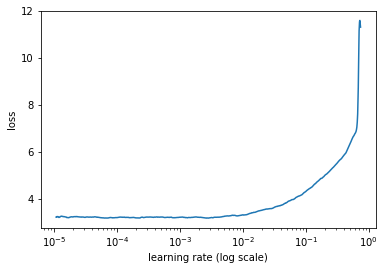

 81%|████████▏ | 1501/1843 [02:10<00:29, 11.54it/s, loss=12.3]

In [35]:
learner.sched.plot()

### helper functions

In [5]:
model_name_base = 'h_cv_class4D_543LR_'+str(n_splits)+'S'
i=0

# function for renaming model and predictions files during CV looping
def get_model_name(base, i):
    name = base+str(i+1)
    print(name)
    return name, i+1

def make_predictions(model, the_df, filename, probabilities=False):
    m = model.model
    m[0].bs = 1
    preds = []
    for i in tnrange(len(the_df)):
        ss = the_df["Description"][i] #Actual text review
        s = [spacy_tok(ss)]
        t = TEXT.numericalize(s)

        m.eval()
        m.reset()
        res,*_ = m(t)
        prediction = LABEL.vocab.itos[to_np(torch.topk(res[-1], 1)[1])[0]]
        if probabilities:
            prediction = to_np(F.softmax(np.exp(res[-1].data))[0])[0]
        preds.append(prediction)
    final_preds = pd.DataFrame({'User_ID': test_df['User_ID'],
                                'Is_Response': preds})
    final_preds[['User_ID', 'Is_Response']].to_csv(filename, index=False)
    print('Finished: '+filename)

# Class needed for sending data to torchtext
class PredictHappinessDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field, device_field, browser_field, dfs, **kwargs):
        fields = [("text", text_field), ("label", label_field), ("device", device_field), ("browser", browser_field) ]
        examples = []
        for i in range(dfs[path].values[:,1].shape[0]):
            text = dfs[path].Description[i]
            label = None
            device = dfs[path].Device_Used[i]
            browser = dfs[path].Browser_Used[i]
            if 'Is_Response' in dfs[path]:
                label = dfs[path].Is_Response[i]
            examples.append(data.Example.fromlist([text, label, device, browser], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, path,
               train, val, test, dfs, device_field, browser_field, **kwargs):
        return super().splits(path,
            text_field=text_field, label_field=label_field, 
            train=train, validation=val, test=test, dfs=dfs, device_field = device_field, browser_field = browser_field, **kwargs)


### Do cross validation for classification model

In [6]:
for (train_ids, val_ids) in tqdm_notebook(cv_splits):
    train_df=full_train_df.iloc[train_ids]
    val_df=full_train_df.iloc[val_ids]

    df = {'train': train_df, 'val': val_df, 'test': None}

    TEXT = pickle.load(open(f'{PATH}models/h5TEXT.pkl','rb'))
    LABEL = data.Field(sequential=False, use_vocab=False, unk_token=None)
    DEVICE = data.Field(sequential=False)
    BROWSER = data.Field(sequential=False)
    splits = PredictHappinessDataset.splits(TEXT, LABEL, '',
                                 train='train',
                                 val='val', test=None, dfs=df, device_field=DEVICE, browser_field=BROWSER)
    md2 = TextData.from_splits(PATH, splits, bs)
    BROWSER.build_vocab(splits[0])
    DEVICE.build_vocab(splits[0])

    # Initialize learner, start training

    dropouti, dropout, wdrop, dropoute, dropouth = np.array([0.05,0.05,0.1,0.02,0.05])*4
    m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
               dropouti=dropouti, dropout=dropout, wdrop=wdrop,
                           dropoute=dropoute, dropouth=dropouth)
    m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
    m3.load_encoder(f'h5_adam6_enc')
    m3.clip=25.
    lrs=np.array([1e-5,1e-4,1e-3])

    # start training

    m3.freeze_to(-1)
    m3.fit(lrs/2, 1, metrics=[accuracy])
    m3.unfreeze()
    m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)
    m3.fit(lrs, 4, metrics=[accuracy], cycle_len=1, cycle_mult=2)

    # train a bit more with low clip

    tmp_model_name, i = get_model_name(model_name_base, i)
    m3.clip=0.03
    m3.fit(lrs, 1, metrics=[accuracy])
    m3.save(tmp_model_name)
    #make_predictions(m3, test_df, SUBS+'/'+tmp_model_name+'.csv', probabilities=True)

[ 0.       0.32843  0.28635  0.8866 ]                          


[ 0.       0.26446  0.24292  0.90335]                          


[ 0.       0.26667  0.23253  0.90696]                          
[ 1.       0.25905  0.2232   0.91237]                          
[ 2.       0.23735  0.22122  0.91366]                          
[ 3.       0.27489  0.21866  0.91211]                          
[ 4.       0.23413  0.21622  0.9134 ]                          
[ 5.       0.20991  0.21637  0.91495]                          
[ 6.       0.20167  0.21602  0.91624]                          
[ 7.       0.24034  0.21467  0.91572]                          
[ 8.       0.22643  0.2195   0.9134 ]                          
[ 9.       0.22201  0.21475  0.91546]                          
[ 10.        0.21867   0.21712   0.91675]                      
[ 11.        0.2129    0.21436   0.91753]                      
[ 12.        0.20466   0.2146    0.91572]                      
[ 13.        0.21094   0.21561   0.91546]                      
[ 14.        0.20863   0.21593   0.91598]                      
h_cv_class4D_543LR_10S1


[ 0.       0.22319  0.22714  0.91572]                          


[ 0.       0.3273   0.29057  0.8817 ]                          


[ 0.       0.27633  0.23023  0.90747]                          


[ 0.       0.2508   0.22123  0.91289]                          
[ 1.       0.24734  0.22173  0.91366]                          
[ 2.       0.24495  0.2112   0.91521]                          
[ 3.       0.26653  0.2076   0.91495]                          
[ 4.       0.22374  0.20738  0.9201 ]                          
[ 5.       0.23392  0.20397  0.9183 ]                          
[ 6.       0.23546  0.204    0.92062]                          
[ 7.       0.2064   0.20532  0.91959]                          
[ 8.       0.24003  0.2104   0.90979]                          
[ 9.       0.21308  0.20875  0.92113]                          
[ 10.        0.21506   0.20133   0.91778]                      
[ 11.        0.2219    0.20154   0.91959]                      
[ 12.        0.20765   0.20096   0.91907]                      
[ 13.        0.21732   0.20043   0.92088]                      
[ 14.        0.21136   0.20042   0.91959]                      
h_cv_class4D_543LR_10S2


[ 0.       0.24049  0.207    0.92036]                          


[ 0.       0.32853  0.29241  0.87964]                          


[ 0.       0.26552  0.24449  0.90129]                          


[ 0.       0.27906  0.23291  0.90541]                          
[ 1.       0.28017  0.22735  0.90644]                          
[ 2.       0.25865  0.22636  0.90644]                          
[ 3.       0.25665  0.22305  0.90979]                          
[ 4.       0.21647  0.22435  0.91417]                          
[ 5.       0.20477  0.22396  0.90979]                          
[ 6.       0.22643  0.22043  0.91134]                          
[ 7.       0.22378  0.22264  0.91495]                          
[ 8.       0.22565  0.22171  0.91211]                          
[ 9.       0.22864  0.21829  0.91521]                          
[ 10.        0.21366   0.22258   0.91005]                      
[ 11.        0.18481   0.21971   0.91443]                      
[ 12.        0.21339   0.2169    0.91624]                      
[ 13.        0.22167   0.21766   0.91649]                      
[ 14.        0.19338   0.21783   0.91495]                      
h_cv_class4D_543LR_10S3


[ 0.       0.21666  0.23525  0.91211]                          


[ 0.       0.35839  0.28643  0.88428]                          


[ 0.       0.28485  0.24807  0.90129]                          


[ 0.       0.26656  0.23755  0.90387]                          
[ 1.       0.23387  0.23053  0.90644]                          
[ 2.       0.24264  0.22881  0.90567]                          
[ 3.       0.25114  0.22745  0.90954]                          
[ 4.       0.22588  0.22659  0.90928]                          
[ 5.       0.2425   0.2244   0.90799]                          
[ 6.       0.23963  0.22511  0.9067 ]                          
[ 7.       0.23715  0.23082  0.90541]                          
[ 8.       0.22386  0.22454  0.90851]                          
[ 9.       0.20429  0.23058  0.90593]                          
[ 10.        0.20453   0.2271    0.91005]                      
[ 11.        0.2192    0.22635   0.90851]                      
[ 12.        0.21689   0.22491   0.90928]                      
[ 13.        0.18283   0.22554   0.90928]                      
[ 14.        0.21098   0.22595   0.90928]                      
h_cv_class4D_543LR_10S4


[ 0.       0.21656  0.24496  0.90696]                          


[ 0.       0.34847  0.29622  0.87603]                          


[ 0.       0.27599  0.23829  0.90619]                          


[ 0.       0.24319  0.23047  0.91082]                          
[ 1.       0.26198  0.22388  0.91211]                          
[ 2.       0.23265  0.22417  0.91186]                          
[ 3.       0.2086   0.22473  0.91134]                          
[ 4.       0.21882  0.22031  0.91186]                          
[ 5.       0.23463  0.21837  0.91289]                          
[ 6.       0.20772  0.2188   0.91314]                          
[ 7.       0.23261  0.21762  0.91366]                          
[ 8.       0.20945  0.21744  0.91495]                          
[ 9.       0.20686  0.22245  0.91314]                          
[ 10.        0.22806   0.21508   0.91546]                      
[ 11.        0.20464   0.22291   0.91443]                      
[ 12.        0.19751   0.21721   0.91521]                      
[ 13.        0.19433   0.21756   0.91546]                      
[ 14.        0.20596   0.21737   0.91521]                      
h_cv_class4D_543LR_10S5


[ 0.       0.21006  0.23281  0.91495]                          


[ 0.       0.33341  0.28577  0.88608]                          


[ 0.       0.27599  0.24135  0.90155]                          


[ 0.       0.25806  0.23254  0.90619]                          
[ 1.       0.2531   0.22646  0.90851]                          
[ 2.       0.23915  0.22466  0.91005]                          
[ 3.       0.27459  0.22111  0.9116 ]                          
[ 4.       0.24012  0.22051  0.9116 ]                          
[ 5.       0.21657  0.22161  0.9116 ]                          
[ 6.       0.21444  0.21917  0.91263]                          
[ 7.       0.24271  0.21772  0.91495]                          
[ 8.       0.23381  0.21609  0.91521]                          
[ 9.       0.20116  0.22011  0.91521]                          
[ 10.        0.21407   0.21639   0.91598]                      
[ 11.        0.19075   0.21835   0.91624]                      
[ 12.        0.21516   0.21594   0.91727]                      
[ 13.        0.2221    0.21559   0.91753]                      
[ 14.        0.20805   0.21668   0.91649]                      
h_cv_class4D_543LR_10S6


[ 0.       0.23217  0.22044  0.91624]                          


[ 0.       0.33789  0.29253  0.87448]                          


[ 0.       0.26613  0.23329  0.90516]                          


[ 0.       0.25536  0.22098  0.91082]                          
[ 1.       0.25849  0.21184  0.91392]                          
[ 2.       0.24077  0.21087  0.91469]                          
[ 3.       0.22691  0.20869  0.91521]                          
[ 4.       0.22561  0.20761  0.91598]                          
[ 5.       0.21881  0.20645  0.91753]                          
[ 6.       0.23721  0.20593  0.91753]                          
[ 7.       0.22672  0.20777  0.91624]                          
[ 8.       0.22189  0.20838  0.91727]                          
[ 9.       0.20549  0.2062   0.91907]                          
[ 10.        0.20506   0.20633   0.92165]                      
[ 11.        0.21257   0.20409   0.91985]                      
[ 12.        0.18862   0.20749   0.92113]                      
[ 13.        0.20567   0.20451   0.91985]                      
[ 14.        0.19932   0.20484   0.92036]                      
h_cv_class4D_543LR_10S7


[ 0.       0.20603  0.21678  0.92036]                          


[ 0.       0.32811  0.28695  0.88737]                          


[ 0.       0.27451  0.23922  0.90051]                          


[ 0.       0.26091  0.23213  0.90387]                          
[ 1.       0.24869  0.22945  0.90696]                          
[ 2.       0.25136  0.22708  0.90825]                          
[ 3.       0.2681   0.22573  0.90851]                          
[ 4.       0.22387  0.22671  0.90825]                          
[ 5.       0.2318   0.22407  0.90954]                          
[ 6.       0.22542  0.2237   0.90954]                          
[ 7.       0.20976  0.22798  0.91314]                          
[ 8.       0.23012  0.22043  0.90979]                          
[ 9.       0.22066  0.22359  0.91237]                          
[ 10.        0.22059   0.22102   0.91289]                      
[ 11.        0.22957   0.2202    0.91366]                      
[ 12.        0.20469   0.22113   0.91289]                      
[ 13.        0.20954   0.22197   0.91417]                      
[ 14.        0.19435   0.22166   0.91392]                      
h_cv_class4D_543LR_10S8


[ 0.       0.20404  0.23572  0.91057]                          


[ 0.       0.32041  0.29236  0.88144]                          


[ 0.       0.2917   0.23694  0.91289]                          


[ 0.       0.24352  0.22774  0.91366]                          
[ 1.       0.24872  0.2256   0.91289]                          
[ 2.       0.25162  0.22141  0.91469]                          
[ 3.      0.2283  0.2229  0.9134]                              
[ 4.       0.23464  0.21623  0.91443]                          
[ 5.       0.23286  0.21662  0.91469]                          
[ 6.       0.23022  0.21609  0.91546]                          
[ 7.       0.24821  0.21549  0.91572]                          
[ 8.       0.23513  0.21985  0.91392]                          
[ 9.       0.24446  0.21494  0.91495]                          
[ 10.        0.22497   0.21295   0.91701]                      
[ 11.        0.19984   0.21253   0.91959]                      
[ 12.        0.20011   0.21223   0.91933]                      
[ 13.        0.19093   0.21157   0.92036]                      
[ 14.        0.20055   0.21147   0.92036]                      
h_cv_class4D_543LR_10S9


[ 0.       0.20355  0.22166  0.91856]                          


[ 0.       0.35321  0.28643  0.88247]                          


[ 0.       0.25104  0.23354  0.90954]                          


[ 0.       0.25285  0.22366  0.91289]                          
[ 1.       0.24783  0.22045  0.91134]                          
[ 2.       0.24186  0.21557  0.91443]                          
[ 3.       0.24628  0.21263  0.91701]                          
[ 4.       0.22853  0.21273  0.91675]                          
[ 5.       0.23733  0.20868  0.91675]                          
[ 6.       0.23072  0.20956  0.91649]                          
[ 7.       0.24126  0.20731  0.91624]                          
[ 8.       0.21067  0.21115  0.9183 ]                          
[ 9.       0.2345   0.2057   0.91804]                          
[ 10.        0.2134    0.2085    0.91675]                      
[ 11.        0.19959   0.2085    0.9183 ]                      
[ 12.        0.20376   0.20791   0.91727]                      
[ 13.        0.2034    0.20717   0.91907]                      
[ 14.        0.19797   0.20735   0.91856]                      
h_cv_class4D_543LR_10S10


[ 0.       0.20846  0.21717  0.92088]                          

